# Running multiple models with BMI in one "Framework"
## Conceptual Functional Equivalent (CFE) Model
## Penman function for an estimate of evaporation
## Bucket model representing some downstream reservoir

In [1]:
#import os
#os.getcwd()

In [2]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da

import sys
#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT')

import bmi_usgs

### Create an instance of the model with a specific configuration that corresponds to a particular catchmenmt.

In [3]:
print(bmi_usgs)
print(bmi_cfe_peturb)
print(Bmi_da)

<module 'bmi_usgs' from 'C:\\Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT\\bmi_usgs.py'>
<module 'bmi_cfe_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_peturb.py'>
<module 'Bmi_da' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da.py'>


In [4]:
USGS_instance = bmi_usgs.BMI_USGS()
cfe_instance_peturb = bmi_cfe_peturb.BMI_CFE()
cfe_instance = bmi_cfe.BMI_CFE()
cfe_assimilation = Bmi_da.NGEN_DA()



print("Input variables:\n")
print("USGS")
print(USGS_instance.get_input_var_names())
print("CFE")
print(cfe_instance_peturb.get_input_var_names())
print("Assimilatoin")
print(cfe_assimilation.get_input_var_names())

print("\nOutput variables:")
print(cfe_assimilation.get_output_var_names())
print(USGS_instance.get_output_var_names())

print(cfe_assimilation.get_var_units('sim'))

#print(cfe_assimilation.cfg_bmi)


Input variables:

USGS
['sites', 'service', 'start', 'end']
CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']
Assimilatoin
['sim', 'obs']

Output variables:
['assimilation']
['Flow', 'validity']
cfs


### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [5]:
#USGS_instance.initialize(cfg_file='/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT/usgs_config.json')
USGS_instance.initialize(cfg_file='C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT/usgs_config.json')
cfe_instance_peturb.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_assimilation.initialize(bmi_cfg_file_name='./Assimilation/config.yml')
#cfe_assimilation.initialize('config.yml')


In [6]:
print(USGS_instance.get_input_var_names())
print(cfe_instance_peturb.get_input_var_names())
print(cfe_instance.get_input_var_names())
print(cfe_assimilation.get_output_var_names())


['sites', 'service', 'start', 'end']
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']
['assimilation']


### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [7]:
with open(cfe_instance_peturb.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)

                    time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0    2015-12-01 00:00:00           0.0     361.200012       0.000000   
1    2015-12-01 01:00:00           0.0     361.200012       0.000000   
2    2015-12-01 02:00:00           0.0     361.200012       0.000000   
3    2015-12-01 03:00:00           0.0     357.600006       0.000000   
4    2015-12-01 04:00:00           0.0     357.600006       0.000000   
..                   ...           ...            ...            ...   
715  2015-12-30 19:00:00           4.7     402.200012     163.600006   
716  2015-12-30 20:00:00           3.7     402.200012     130.300003   
717  2015-12-30 21:00:00           4.2     399.200012      80.400002   
718  2015-12-30 22:00:00           8.3     399.200012      21.000000   
719  2015-12-30 23:00:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0        100530.0              0.0105         287.5000

### We will want to visualize the model output

In [8]:
# Originial CFE Model
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

# CFE Peturbed
cfe_outputs_peturb=cfe_instance_peturb.get_output_var_names()
cfe_output_lists_peturb = {output_peturb:[] for output_peturb in cfe_outputs_peturb}

# USGS
USGS_outputs=USGS_instance.get_output_var_names()
USGS_output_lists = {output:[] for output in USGS_outputs}

# Assimilation
outputs_assimilation=cfe_assimilation.get_output_var_names()
outputs_lists_assimilation = {output_assimilation:[] for output_assimilation in outputs_assimilation}

print(USGS_output_lists)
print(cfe_output_lists_peturb)
print(cfe_output_lists)
print(outputs_lists_assimilation)


{'Flow': [], 'validity': []}
{'land_surface_water__runoff_depth_ens': []}
{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}
{'assimilation': []}


### Now we loop through the forcing data and use it to run the model at each time step

In [9]:
########################################
# Loop through all of forcing data; model and peturbed

    # Keep track of time
    
    # Set forcing data for model
    # Set forcing for peturbed models. Aren't they using the same forcing data?
    
    # Update model
    
    # Update observation data
    
    # Update ensemble of peturbed models 
        
    # Update DA   
    
    # Get value of DA and set value to model
    
    # Set value of streamflow. Depending on this, we will change state variables below
        # Schaake_output_runoff_m
        # soil_reservoir_storage_deficit_m
        # ground water storage deficity 
        # Covary the runoff_queue_m_per_timestep, line 183, cfe.py
        
        

In [10]:
# Make empty matrices for plotting
sim = []
obs = []
assimilation = []
cfe = []

# Run USG model
USGS_instance.update()
obs = USGS_instance.get_value('Flow')
#print(obs)

for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Run CFE model
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance.update()
    outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe.append(outflow)
    
    # Peturbation run   
    cfe_instance_peturb.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance_peturb.update()
    outflow_peturb = cfe_instance_peturb.get_value('land_surface_water__runoff_depth_ens')
    
    # Calculate states of ensemble runs
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_std = np.std(outflow_peturb)
    outflow_peturb_var = np.var(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    
    #obs.append(outflow_peturb_std)
    sim.append(outflow_peturb_mean)
    
    # Assimilation
    cfe_assimilation.set_value('obs', obs[i]*10) #need these to represent pdf of flows
    cfe_assimilation.set_value('sim', outflow_peturb_mean)
    cfe_assimilation.update()
    
    # Make matrix to put assimilation output
    output = np.zeros(1)
    DA_output = cfe_assimilation.get_value('assimilation', output)
    #print(DA_output)
    assimilation.append(DA_output) #append empty matrix to output for plotting
    
print(outflow_peturb_covar)
print(outflow_peturb_mean)
        


                         Date    Flow  validity
0   2015-12-01 07:00:00+00:00  2.4375       1.0
1   2015-12-01 08:00:00+00:00  2.4250       1.0
2   2015-12-01 09:00:00+00:00  2.4275       1.0
3   2015-12-01 10:00:00+00:00  2.4125       1.0
4   2015-12-01 11:00:00+00:00  2.3900       1.0
..                        ...     ...       ...
715 2015-12-31 02:00:00+00:00  2.4200       1.0
716 2015-12-31 03:00:00+00:00  2.4250       1.0
717 2015-12-31 04:00:00+00:00  2.4225       1.0
718 2015-12-31 05:00:00+00:00  2.4200       1.0
719 2015-12-31 06:00:00+00:00  2.3500       1.0

[720 rows x 3 columns]
USGS station ID 10109000
263.75009028083457
25.240933599533577


In [11]:
sum_peturb = np.sum(sim)
sum_cfe = np.sum(cfe)
percent_diff = ((sum_peturb - sum_cfe) / sum_peturb)
print('Percenter Difference', percent_diff * 100)

Percenter Difference -53.87925164038623


### The finalize function should perform all tasks that take place after exiting the model’s time loop. This typically includes deallocating memory, closing files and printing reports.

In [12]:
cfe_instance.finalize(print_mass_balance=False)
cfe_instance_peturb.finalize(print_mass_balance=False)

### Here we are just plotting the fluxes.

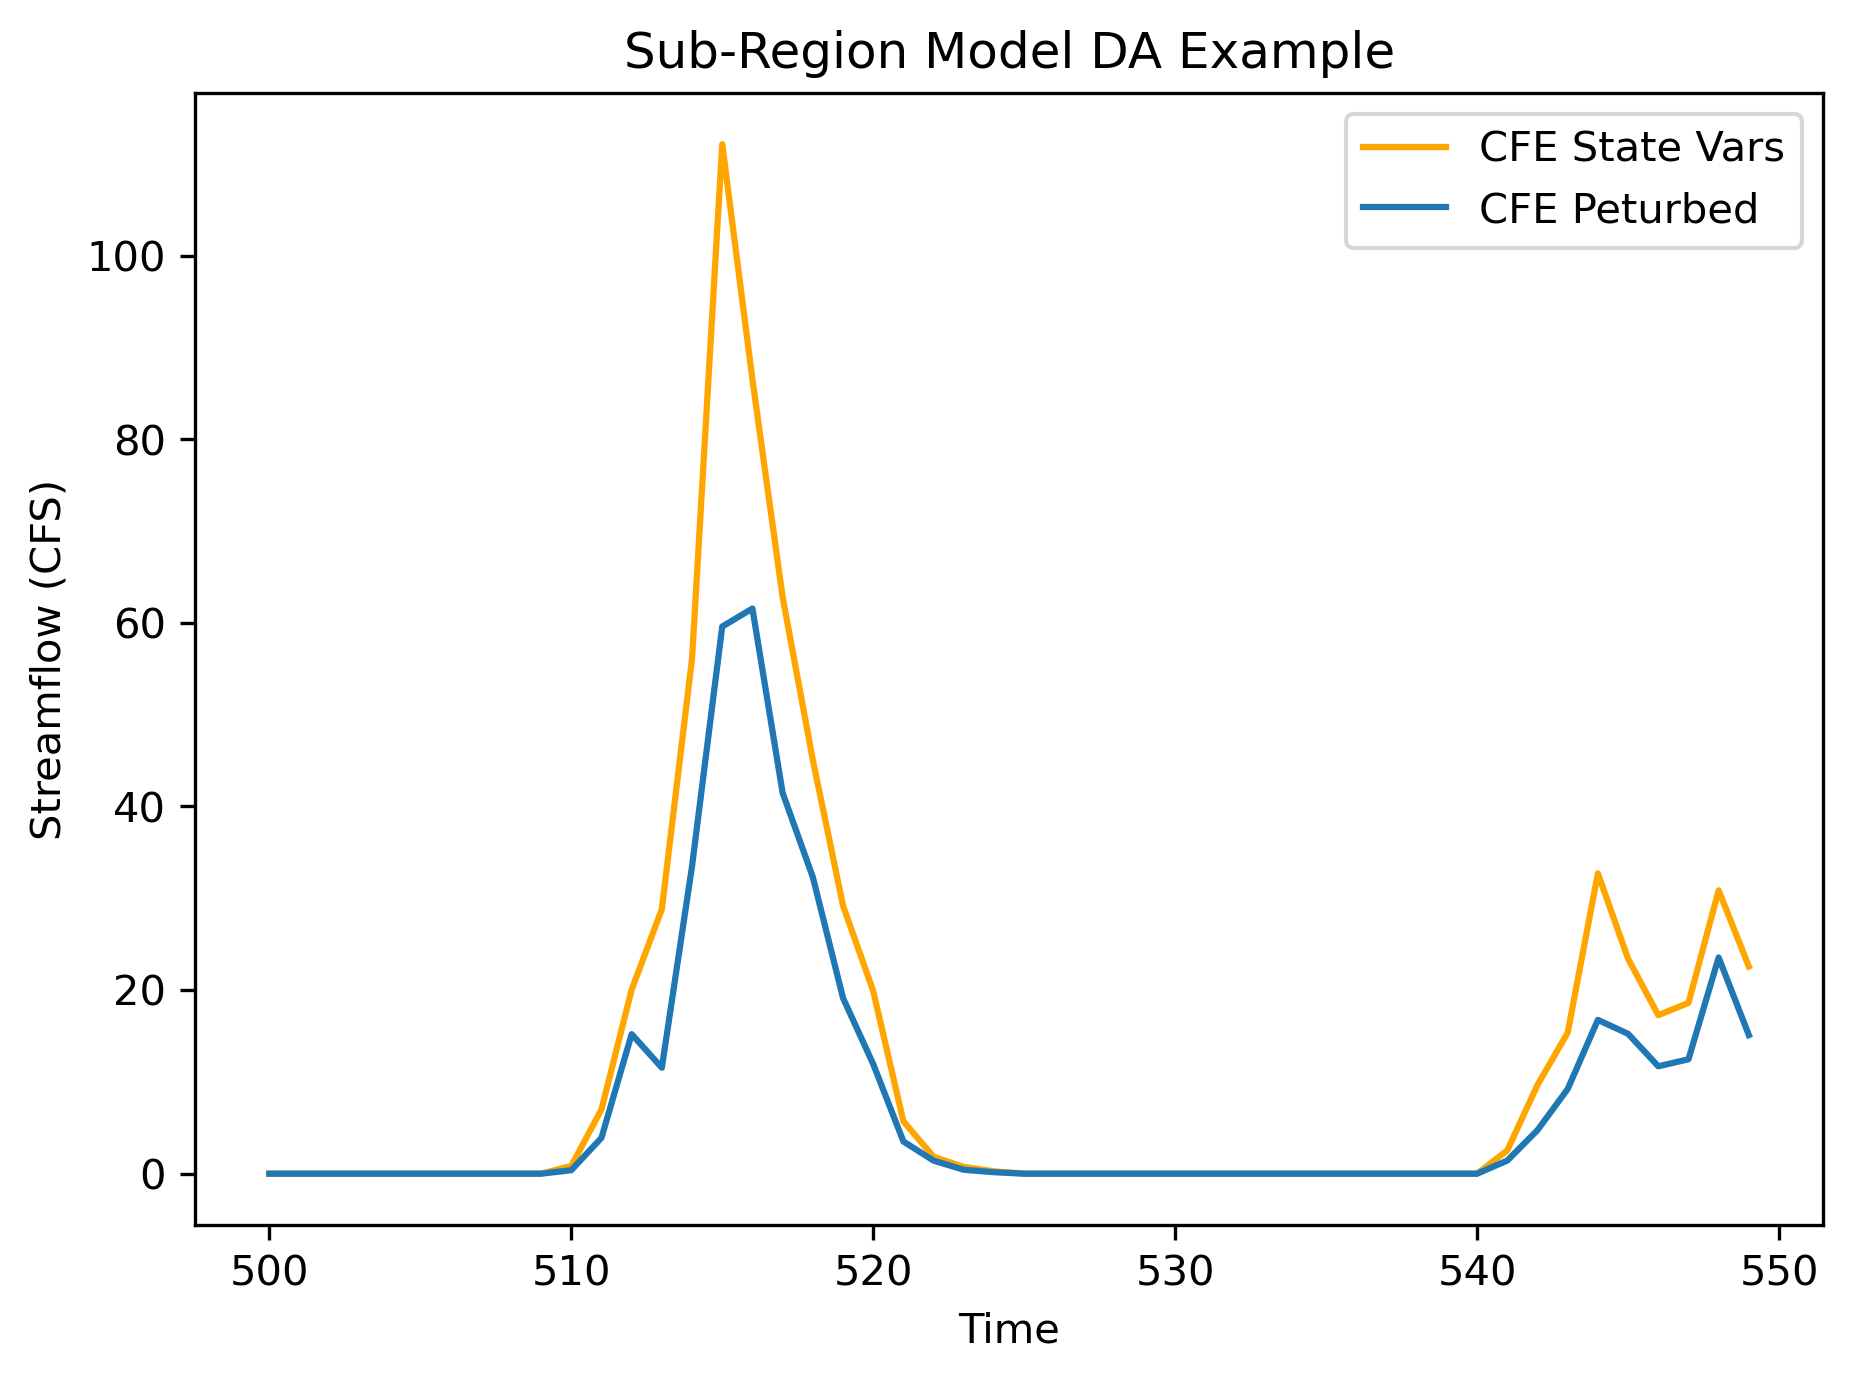

In [13]:
istart_plot=500
iend_plot=550
x = list(range(istart_plot, iend_plot))

fig = plt.figure(figsize = (7,5), dpi=300)

plt.plot(x, cfe[istart_plot:iend_plot], color = 'orange', label = 'CFE State Vars')

plt.title('Sub-Region Model DA Example')
plt.plot(x, sim[istart_plot:iend_plot], color = 'tab:blue', label = 'CFE Peturbed')
#plt.plot(x, assimilation[istart_plot:iend_plot], color = 'green', label = 'DA')
#plt.plot(x, obs[istart_plot:iend_plot]*10, color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
plt.ylabel('Streamflow (CFS)')
plt.xlabel('Time')
plt.legend()


### Here we are just going to run the unit test that compares with the origional author code. Kind of the same thing done above, but there is a function in the BMI code that does it all at once.